<a href="https://colab.research.google.com/github/Ahmed-Magdi1/2DOF-Helicopter-NARX_BPTT_Adam/blob/v.1/NARX_update.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import necessary libraries

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

## 1. Load the Data


In [9]:
# Load sensor data (exogenous inputs)
df_inputs = pd.read_csv('inputs.csv')  # Expected columns: Voltage, Pitch_Current, Yaw_Current, Pitch_PWM, Yaw_PWM

# Load encoder data (system outputs)
df_outputs = pd.read_csv('outputs.csv')  # Expected columns: Pitch_Angle, Yaw_Angle

In [10]:
# Quick check of the data
print("Sensor Data (Inputs):")
print(df_inputs.head())
print("\nEncoder Data (Outputs):")
print(df_outputs.head())

Sensor Data (Inputs):
   Voltage  Pitch_Current  Yaw_Current  Pitch_PWM  Yaw_PWM
0    12.91            0.0          0.0       1500     1214
1    12.91            0.0          0.0       1500     1204
2    12.91            0.0          0.0       1500     1193
3    12.91            0.0          0.0       1500     1186
4    12.91            0.0          0.0       1500     1186

Encoder Data (Outputs):
   Pitch_Angle  Yaw_Angle
0          0.0        0.0
1          0.0        0.0
2          0.0        0.0
3          0.0        0.0
4          0.0        0.0


In [11]:
# Ensure both dataframes have the same number of rows
assert len(df_inputs) == len(df_outputs), "The number of samples in the two files must match!"

# Extract arrays from the DataFrames
# u: Exogenous inputs [Voltage, Pitch_Current, Yaw_Current, Pitch_PWM, Yaw_PWM]
u = df_inputs[['Voltage', 'Pitch_Current', 'Yaw_Current', 'Pitch_PWM', 'Yaw_PWM']].values  # Shape: (N, 5)
# y: Outputs [Pitch_Angle, Yaw_Angle]
y = df_outputs[['Pitch_Angle', 'Yaw_Angle']].values  # Shape: (N, 2)

## 2. Create the NARX Dataset

In [12]:
# We'll choose a lag order (number of past time steps) for both inputs and outputs.
lag_order = 3  # You can adjust this based on your system dynamics

def create_narx_dataset(y, u, lag):
    """
    Create a dataset for a NARX model.
    For each time step t, features are formed from:
      [y(t-1), y(t-2), ..., y(t-lag), u(t-1), u(t-2), ..., u(t-lag)]
    and the target is y(t).
    """
    X, Y_target = [], []
    for t in range(lag, len(y)):
        # Flatten lagged outputs and inputs into one feature vector
        past_y = y[t-lag:t].flatten()  # Shape: (lag * 2,)
        past_u = u[t-lag:t].flatten()  # Shape: (lag * 5,)
        features = np.concatenate([past_y, past_u])
        X.append(features)
        Y_target.append(y[t])
    return np.array(X), np.array(Y_target)

X, Y_target = create_narx_dataset(y, u, lag_order)
print("\nFeature matrix shape:", X.shape)  # Expected shape: (samples, lag*(2+5))
print("Target matrix shape:", Y_target.shape)  # Expected shape: (samples, 2)


Feature matrix shape: (57638, 21)
Target matrix shape: (57638, 2)


## 3. Split the Data

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_target, test_size=0.2, random_state=42)

## 4. Build and Train the Model

In [14]:
# Here we build a simple feedforward neural network to learn the mapping.
model = Sequential([
    Dense(64, activation='relu', input_shape=(X.shape[1],)),
    Dense(64, activation='relu'),
    Dense(Y_target.shape[1])  # Output layer with 2 neurons (Pitch_Angle and Yaw_Angle)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 64)                  │           1,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,698 (22.26 KB)

 Trainable params: 5,698 (22.26 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Train the model
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 1268.2856 - val_loss: 8.9876
Epoch 2/50
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 8.8081 - val_loss: 3.1348
Epoch 3/50
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 3.6576 - val_loss: 3.4237
Epoch 4/50
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.5587 - val_loss: 0.4616
Epoch 5/50
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.6606 - val_loss: 2.3005
Epoch 6/50
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 2.5906 - val_loss: 0.5864
Epoch 7/50
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 2.4987 - val_loss: 3.4460
Epoch 8/50
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 2.0121 - val_loss: 1.4072
Epoch 9/50
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.8234 - val_loss: 14.4404
Epoch 10/50
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 1.7293 - val_loss: 0.3153
Epoch 11/50
1297/1297 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 1.3009 - val_loss: 1.1069
Epoch 12/50
1297/1297 ━━━━

## 5. Evaluate the Model

In [16]:
test_loss = model.evaluate(X_test, Y_test)
print("\nTest Loss:", test_loss)

361/361 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0396

Test Loss: 0.03914488106966019


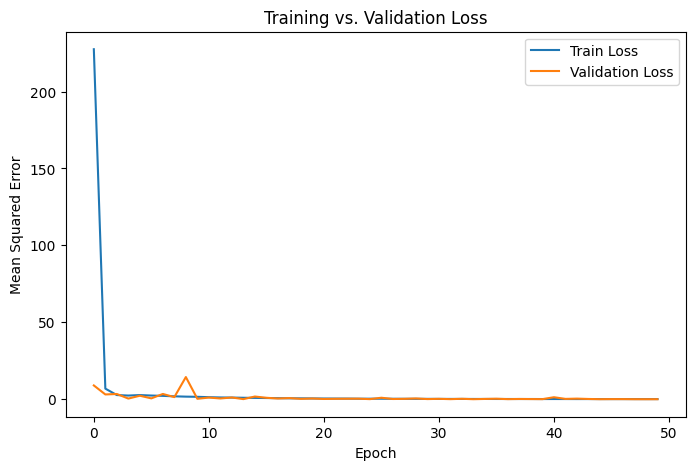

In [17]:
# Plot training and validation loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.show()

In [18]:
model.save('narx_model.h5')